# B. Learning pendulum dynamics

In this notebook we follow on from the first tutorial (A. Pendulum dynamics outline) to explore learning the dynamics of a pendulum using a Koopman operator theory based deep learning approach. 

The examples here use the method created by [^fn1], and are run using a modified version of the Keras implementation from [^fn3]).

This notebook is primarily focused on presenting and analysing the spectral outputs (e.g. eigenfunctions) of the learnt model (the later sections of this notebook). To help elucidate these results, a modified implementation of [^fn3] is also included here. As the focus of this repository is on tutorials, technical/implementation details are secondary, and as such this code might not be able to run as is.

[^fn1]: Lusch, B., Kutz, J.N. & Brunton, S.L. Deep learning for universal linear embeddings of nonlinear dynamics. Nat Commun 9, 4950 (2018). https://doi.org/10.1038/s41467-018-07210-0

[^fn3]: https://github.com/dykuang/Deep----Koopman


# i) Creating the model

## Generate data

Firstly a dataset of pendulum swings should be generated. The notebook 'Generate pendulum data.ipynb' should be run, with the following control options:

- pendulum_type = 'rigid'
- control = False
- friction = 0

This will generate six datasets into the 'data' subdirectory:

- train/test/valid : Randomly generated trajectories of motion
- top/mid/bottom : Lengthy trajectories initialised at specific angles, to visualise different states

In [1]:
# Variables for learning
BATCH_SIZE = 128
EPOCHS = 1000

In [2]:
# Fix the seed, for evaluation
seed = 42
import random
random.seed(seed)
import numpy as np
np.random.seed(seed)

## Load the datasets

This code uses a modified version of the Keras-HDF5-ImageDataGenerator, where modifications perform augmentations of the output.

This modification included in this repository's libraries folder, and is also avaliable at https://gitlab.com/Brendan_Michael/Keras-HDF5-ImageDataGenerator


In [ ]:
import h5py
import sys
sys.path.append('./libraries/Keras-HDF5-ImageDataGenerator/')
from h5imagegenerator.generator import HDF5ImageGenerator
from albumentations import Compose,Crop,ToFloat,Normalize

xmax_state = 2  # Number of state variables
num_control = 0 # Number of control variables
DATA_TIMESTEPS = 50

# Trim any extra timesteps
augmentor = Compose([
    Crop(x_min=0,  x_max=xmax_state,y_min=0,y_max=DATA_TIMESTEPS),
])
augmenter_labels = Compose([
    Crop(x_min=0,  x_max=xmax_state,y_min=0,y_max=DATA_TIMESTEPS),
])

# Set keys
X_key = 'state_t'
y_key = 'state_tp1'
classes_key = 'state_tp1'

# Define generators on the HDF5 files
# By using generators, we don't need to load all samples into memory at once. Its a bit slower, but it means we can used many more samples
# Define a generator where input is state at t, and output is state at t+1
train_generator = HDF5ImageGenerator(
        src = './data/train.hdf5',
        X_key=X_key,
        y_key=y_key,
        classes_key = classes_key,
        scaler=False, # This assumes inputs are [0,255] (standard images), and shouldn't be used. Instead normalise as explict layer
        labels_encoding=False, # this is fine, as its regression
        batch_size=BATCH_SIZE,
        mode='train',
        augmenter=augmentor,
        augmenter_labels = augmenter_labels, # also crop the outputs
        shuffle=True,
)

valid_generator = HDF5ImageGenerator(
        src='./data/valid.hdf5',
        X_key=X_key,
        y_key=y_key,
        classes_key = classes_key,
        scaler=False,
        labels_encoding=False,
        batch_size=BATCH_SIZE,
        mode='train',
        augmenter=augmentor,
        augmenter_labels = augmenter_labels, 
        shuffle=True,
)

test_generator = HDF5ImageGenerator(
        src='./data/test.hdf5',
        X_key=X_key,
        y_key=y_key,
        classes_key = classes_key,
        scaler=False,
        labels_encoding=False,
        batch_size=BATCH_SIZE,
        mode='train', 
        augmenter=augmentor,
        augmenter_labels = augmenter_labels, 
        shuffle=True,
)

EVALUATION_INTERVAL = len(train_generator._indices) // BATCH_SIZE
VALIDATION_STEPS = len(valid_generator._indices) // BATCH_SIZE


# Define generators for the long term data. This is used to compare against predictions made far into the future, and are not used for training.
NUM_DELAYS = 969

long_generator_predict = HDF5ImageGenerator(
        src = './data/top.hdf5',
        X_key=X_key,
        y_key=y_key,
        classes_key = classes_key,
        scaler=False, # This assumes inputs are [0,255] (standard images), and shouldn't be used. Instead normalise as explict layer
        labels_encoding=False, # this is fine, as its regression
        batch_size=NUM_DELAYS,
        mode='train',
        augmenter=augmentor,
        augmenter_labels = augmenter_labels, # also crop the outputs
        shuffle=True,
)

mid_generator_predict = HDF5ImageGenerator(
        src = './data/mid.hdf5',
        X_key=X_key,
        y_key=y_key,
        classes_key = classes_key,
        scaler=False, # This assumes inputs are [0,255] (standard images), and shouldn't be used. Instead normalise as explict layer
        labels_encoding=False, # this is fine, as its regression
        batch_size=NUM_DELAYS,
        mode='train',
        augmenter=augmentor,
        augmenter_labels = augmenter_labels, # also crop the outputs
        shuffle=True,
)

small_generator_predict = HDF5ImageGenerator(
        src = './data/bottom.hdf5',
        X_key=X_key,
        y_key=y_key,
        classes_key = classes_key,
        scaler=False, # This assumes inputs are [0,255] (standard images), and shouldn't be used. Instead normalise as explict layer
        labels_encoding=False, # this is fine, as its regression
        batch_size=NUM_DELAYS,
        mode='train',
        augmenter=augmentor,
        augmenter_labels = augmenter_labels, # also crop the outputs
        shuffle=True,
)


### If the datasets are small enough, load training data into memory instead of generators to speed up learning

In [4]:
load_into_memory = True

In [5]:
if load_into_memory:
    filename = './data/train.hdf5'
    with h5py.File(filename, "r") as f:        
        train_input = f[list(f.keys())[0]][()]  # returns as a numpy array
        train_output = f[list(f.keys())[1]][()]  # returns as a numpy array

    filename = './data/valid.hdf5'
    with h5py.File(filename, "r") as f:    
        valid_input = f[list(f.keys())[0]][()]  # returns as a numpy array
        valid_output = f[list(f.keys())[1]][()]  # returns as a numpy array

    train_input = train_input[:,:,:xmax_state]
    train_output = train_output[:,:,:xmax_state]
    valid_input = valid_input[:,:,:xmax_state]
    valid_output = valid_output[:,:,:xmax_state]


# Visualise trajectories

The goal of learning the pendulum dynamics, is to create a model that allows us to predict future states given current observations. For example, the below image shows sample trajectories, where both the historical data and state is avaliable. The goal is to use that data, to predict what the next state will be.

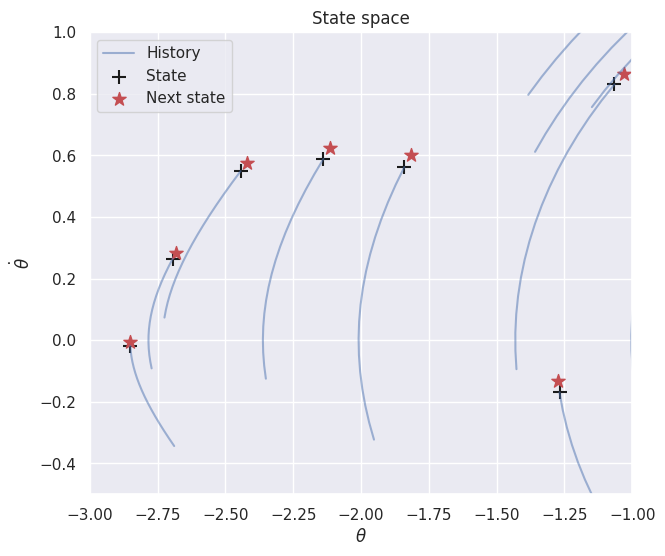

In [6]:
%matplotlib inline
import seaborn as sns
sns.set(font_scale=1)
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7,6))
for i in range(50):
    plt.plot(train_generator[0][0][i,::3,0],train_generator[0][0][i,::3,1],color='b',alpha=0.5,label='History' if i==0 else '')
    plt.scatter(train_generator[0][1][i,-3,0],train_generator[0][1][i,-3,1],color='k',alpha=1,marker='+',s=100,label='State' if i==0 else '')
    plt.scatter(train_generator[0][1][i,-1,0],train_generator[0][1][i,-1,1],color='r',alpha=1,marker='*',s=100,label='Next state' if i==0 else '')
plt.xlim([-3,-1])
plt.ylim([-.5,1])
plt.legend(loc=2)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\dot{\theta}$')
plt.title('State space')
plt.savefig('state_space.png')  

# Define parameters for learning

In [7]:
# Initialise learning and set imports
%killbgscripts
import keras
from keras import backend as K
K.clear_session()
import tensorflow as tf
tf.random.set_seed(seed)
# Needed for running custom loss
from tensorflow.python.framework.ops import disable_eager_execution, enable_eager_execution
disable_eager_execution()
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda
from tensorflow.keras.optimizers import Adam

All background processes were killed.


## Parameterisation

Network parameters are defined according to the Deep Koopman paper

In [8]:
'''
Adapted from https://github.com/dykuang/Deep----Koopman
'''
par = {
       'input steps':DATA_TIMESTEPS,
       'latent steps':DATA_TIMESTEPS,
       'output steps':DATA_TIMESTEPS,
       'pred steps': DATA_TIMESTEPS,
       'batch size': BATCH_SIZE,
       'en dim list': [80,80], # widths of encoder (two layers)
       'de dim list': [80,80], # widths of deencoder (two layers)
       'K reg': 10e-14,
       'epochs': EPOCHS,
       'num complex': 1,  # number of conjugate pairs (only one is needed for pendulum)
       'num real': 0,
       'hidden_widths_omega': [170], # the width of the auxiliary network (one layer)
       'lr': 0.001, 
       'alpha_1' : 0.001, 
        #'alpha_2' : 10e-9, # this is an infinity norm term, but its not used in the code
       'alpha_3' : 10e-14,
       'dt' : 0.02
       }
par['num_samples'], par['time steps'], par['input feature dim'] = train_generator[0][0].shape
par['num_samples'], par['time steps'], par['output feature dim'] = train_generator[0][1].shape
input_shape = (par['input steps'], par['input feature dim'])
output_shape = (par['input steps'], par['output feature dim'])

# Latent dimension
par['latent dim'] = 2*par['num complex'] + par['num real'] # Each complex number is a pair here, so number of dimensions = 2c+r
latent_shape = (par['latent steps'],)+ (par['latent dim'],)

# Define losses

In [9]:
'''
Adapted from https://github.com/dykuang/Deep----Koopman
Loss function is modified here to make it follow the method as outlined in [^fn1]
Specifically, here:
1. Mean squared error is used instead of absolute error
2. An alpha_1 variable is used to control between state loss and reconstruction loss
3. A next step reconstruction loss over m future steps is computed
'''

sys.path.append('./libraries/Deep----Koopman/')


'''
Losses
'''
from keras.losses import mean_squared_error, mean_absolute_error

def S_error(args):
    Y0, Y1 = args
    return tf.reduce_mean(tf.math.squared_difference(Y0,Y1))

# The state loss: g(x_t+1) - Kg(x_t) 
def State_loss(yTrue, yPred):
    return tf.reduce_mean(tf.math.squared_difference(encoder(yTrue),KGx))

# The reconstruction loss: x->g(x)->g^-1(x)->x
def Rec_loss(yTrue, yPred):
    return par['alpha_1']  *  tf.reduce_mean(tf.math.squared_difference(
        x_in[:,:,:xmax_state-num_control],
        decoded_x[:,:,:xmax_state-num_control]))

# The mean reconstruction loss over m steps into the future
def Rec_plus1_loss(yTrue, yPred):
    return par['alpha_1']  *  tf.reduce_mean(tf.math.squared_difference(
        yTrue[:,:,:xmax_state-num_control], # ignore control predictions
        yPred[:,:,:xmax_state-num_control])
                         )

def customLoss():
    # yTrue is the actual value X_t+1
    # yPred is the predicted reconstruction at X_t+1 (as this is the output of full_model, aka decoded_xp)
    # However, yPred is not actally needed when computing the (custom) loss, instead:
    # 1) L_recon is the MSE between X_t and the prediction of X_t
    # 2) L_pred is the MSE between X_t+m and the prediction of X_t+m, over m timesteps
    # 3) L_lin is the MSE between encoder(X_t+m) and the prediction of encoder(X_t+m), over m timesteps
    def Loss(yTrue, yPred): 
        L_recon = Lambda(S_error)([x_in[:,:,:xmax_state-num_control],
                                   decoded_x[:,:,:xmax_state-num_control]])

        # According to ULE paper, this should be over 30 steps, instead of 50.
        L_pred = tf.reduce_mean(tf.math.squared_difference(
            yTrue[:,:,:xmax_state-num_control], # ignore control predictions
            yPred[:,:,:xmax_state-num_control]))

        L_lin = tf.reduce_mean(tf.math.squared_difference(encoder(yTrue),KGx))    

        return  ((par['alpha_1']  * (L_recon+L_pred)) + L_lin)
    return Loss

# Training a model

To create a predictive model, the Deep Koopman network uses an encoder/decoder structure, with an inner latent layer learning the linear dynamics. Specifically, the inner layers learn Koopman eigenfunctions, and linear updates via eigenvalue growths and oscillations. See [^fn1] for details.

In [10]:
'''
Adapted from https://github.com/dykuang/Deep----Koopman
Architecture is modified here to make it follow the method as outlined in [^fn1]
Specifically, here:
1. LSTM layers are replaced with a dense network for the encoder/decoder. LSTMs were never part of the original Deep Koopman paper, and add extra complexity. It is also not clear what effect recurrent nodes has on eigenfunction analysis.
2. Regularizers are added following the Deep Koopman paper
3. Conv1D layers are replaced with a dense network for the hidden widths. Conv1D layers were never part of the original Deep Koopman paper, and it unclear the effect convolution has.
4. linear_update remains mostly the same, but timesteps are computed independently to allow for a control signal to be passed.
'''

from tensorflow.keras.layers import Input, Reshape
from Architecture import _transformer,_pred_K, linear_update,compute_aux_inputs

'''
Input
'''
x_in = Input(input_shape)   


'''
Encoder
Note: historical measurements asre appended into a vector, following Taken's embedding theorem
This is commonly applied in DMD/Koopman-like implementations.
'''    
x_reshape = tf.keras.layers.Reshape((1,np.prod(x_in.shape[1:])))(x_in)
Gx = _transformer(x_reshape, par['latent dim'], par['en dim list'],par['alpha_3'],activation_out='linear')
encoder = Model(x_in, Gx,name="encoder")

'''
linear update in latent space: Predicting via Koopman eigenvalues
'''
CR = compute_aux_inputs(par['num complex'], par['num real'])#compute the auxiliary inputs (complex coordinates are converted to magnitude)
Gx_CR = CR(Gx)
Koop = _pred_K(Gx_CR, par['num complex'], par['num real'],par['hidden_widths_omega'], par['K reg'],par['alpha_3'],activation_out='linear')
LU = linear_update(output_dim = Gx.shape[1:], num_complex = par['num complex'], num_real = par['num real'],dt=par['dt'])
KGx = LU([Gx, Koop])
Knet = Model(x_in, [Koop, KGx]) 

'''
Decoder
'''
decoder_input = Input(shape = Gx.shape[1:])
decoded = _transformer(decoder_input, np.prod(output_shape), par['de dim list'],par['alpha_3'], activation_out='linear')
decoded =  tf.keras.layers.Reshape((x_in.shape[1:]))(decoded) # Reshape back into history
_decoder = Model(decoder_input, decoded,name="decoder")


'''
Outputs
'''
decoded_x = _decoder(Gx)   # Reconstruction of state input
decoded_xp = _decoder(KGx) # Prediction of next step state

'''
Full model
'''
full_model = Model(x_in, decoded_xp)


# Create a  custom Knet to predict only the latent space
'''
Custom Koopman network with input: y_t, and output: y_t+1
In contrast to standard Knet defined above, which takes: input x_t and output: y_t+1 
'''
# Disassemble layers
layers = [l for l in Knet.layers]

# Create a new layer thats the latent input (y_t), instead of the state (x_t)
latent_input = Input(shape = Gx.shape[1:])

# starting layer (after the encoder)
s_layer = len(encoder.layers)

Koop_l = latent_input
# Add the remaining layers, ignoring the LU
for i in range(s_layer,len(layers)-1):
    Koop_l = layers[i] (Koop_l)

# Define new linear update
KGx_l = LU([latent_input, Koop_l])
custom_Knet = Model(latent_input, [Koop_l, KGx_l],name="Koopman network")

In [ ]:
'''
Models
'''
print(encoder.summary())
print(custom_Knet.summary())
print(_decoder.summary())

## Visualise the full model

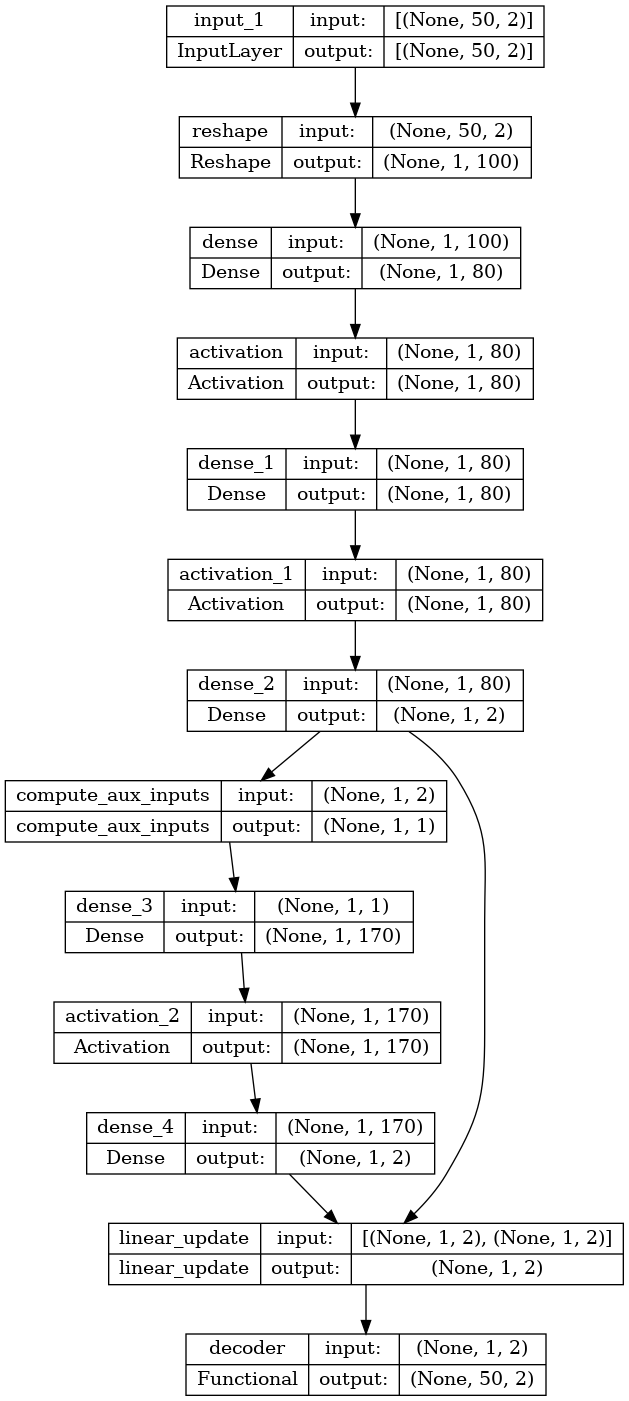

In [12]:
from keras.utils.vis_utils import plot_model
plot_model(full_model, show_shapes=True, show_layer_names=True)

## Train the model

In [ ]:
optimizer=tf.keras.optimizers.legacy.Adam(learning_rate = par['lr'],decay = par['lr']/par['epochs'])

full_model.compile(loss=customLoss(),
                   metrics=[State_loss, Rec_loss,Rec_plus1_loss],
                   optimizer=optimizer,
                  )

if load_into_memory:
    history = full_model.fit(x=train_input,y=train_output,epochs = EPOCHS, verbose=1,
                    validation_data=(valid_input,valid_output),
                    validation_steps=VALIDATION_STEPS,                     
                    batch_size=BATCH_SIZE,
                   )
    
else:
    history = full_model.fit(train_generator,epochs = EPOCHS, verbose=1,
                    validation_data=valid_generator,
                    validation_steps=VALIDATION_STEPS,
                    steps_per_epoch=EVALUATION_INTERVAL,
                   )
history = history.history

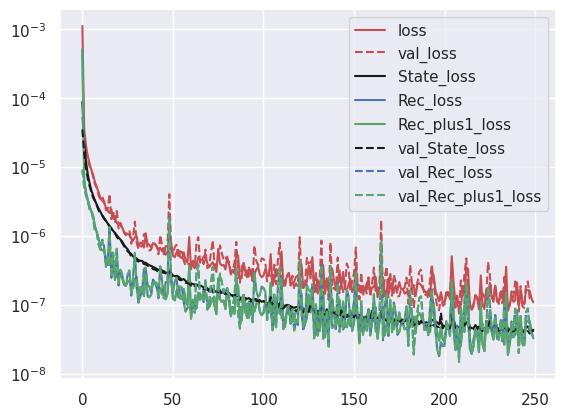

In [14]:
# training loss
plt.figure()
plt.plot((history['loss']), 'r')
plt.plot((history['val_loss']), '--r')
plt.legend(['loss','val_loss'])

plt.plot((history['State_loss']),'k')
plt.plot((history['Rec_loss']), 'b')
plt.plot((history['Rec_plus1_loss']), 'g')
plt.plot((history['val_State_loss']),'--k')
plt.plot((history['val_Rec_loss']), '--b')
plt.plot((history['val_Rec_plus1_loss']), '--g')

plt.legend(['loss','val_loss',
            'State_loss', 'Rec_loss',
            'Rec_plus1_loss', 'val_State_loss',
            'val_Rec_loss','val_Rec_plus1_loss',
           ])
plt.yscale('log')

# ii) Analyse the learnt dynamics model

Given this learnt model, the special components will be examined to determine if the model has captured physicaly-relevant components of the dynamical system.

## Visualise the learnt next step prediction

Examinging the next step prediction shows that the model can successfully predict future timesteps.

Text(0, 0.5, '$\\dot{\\theta}$')

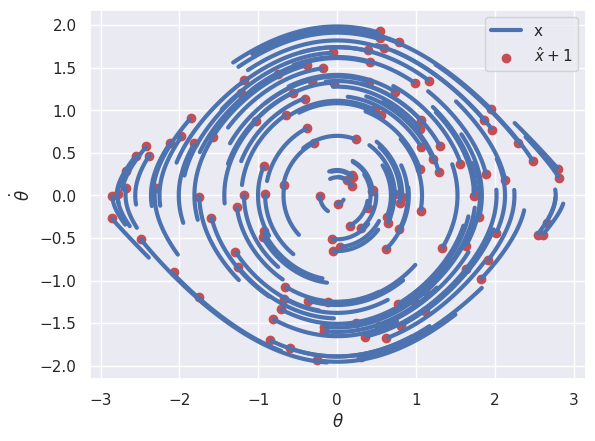

In [20]:
xhat_tp1 = full_model.predict(train_generator[0][0],verbose = 0)
fig = plt.figure()
for j,i in enumerate(range(128)):
    plt.plot(train_generator[0][0][i,:,0],train_generator[0][0][i,:,1],color='b', label = 'x' if j == 0 else "",linewidth=3)
    plt.scatter(xhat_tp1[i,-1,0],xhat_tp1[i,-1,1],color='r', label = r'$\hat{x}+1$' if j == 0 else "")
plt.legend()
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\dot{\theta}$')

# Characterising outputs

Long-term predictions can be made with this model, but key to Deep Koopman is that the model contains spectral components that characterise the actual physical behaviour. It is not good enough to make accurate predictions, these predictions needs to be explainable in the context of dynamical systems.

To explore this, the following diagram displays outputs of the learnt model, mapped onto phase space, latent space, or time series. Following the diagram, a brief explaination of each subplot is given.

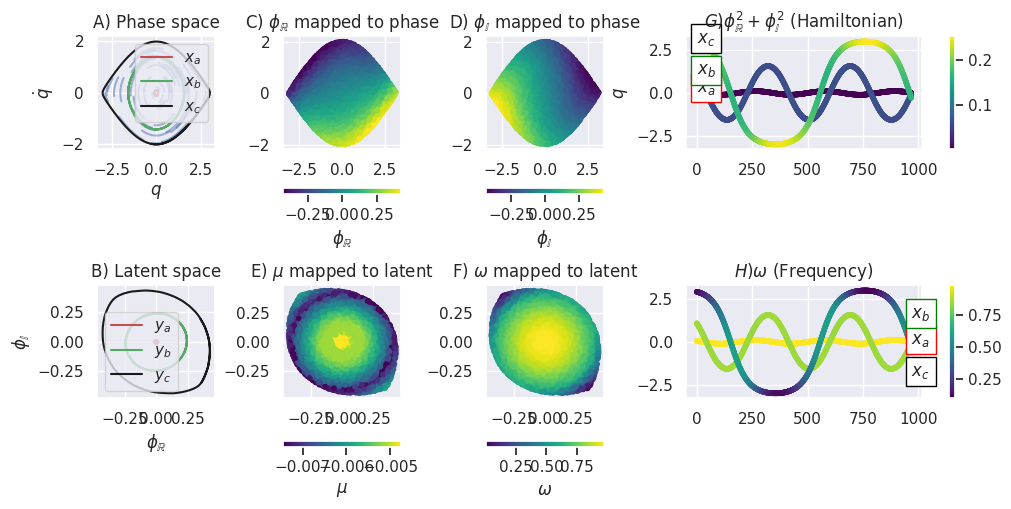

In [19]:
from matplotlib.gridspec import GridSpec

# To make plotting easier, only a few samples are plotted.
num_samples = 50

# Given complex eigenfunctions, this just iterates over the real parts (and the imaginary parts might still be used)
for eigenfunction_num in range(par['num complex']*2)[::2]:

    # To make plotting easier, only use one batch
    batch = 0

    # Define layer
    fig = plt.figure(figsize=(10,5),constrained_layout=True)
    gs = GridSpec(2,5,figure=fig)

    # Plot the input data in A) 
    ax1 = plt.subplot(gs[0,0])
    for i in range(num_samples):
        plt.plot(train_generator[batch][0][i,:,0],train_generator[batch][0][i,:,1],'b',alpha=0.5)
    # Plot the exemplar trajectories
    plt.plot(small_generator_predict[batch][0][:,-1,0],small_generator_predict[batch][0][:,-1,1],'r',label=r'$x_a$')
    plt.plot(mid_generator_predict[batch][0][:,-1,0],mid_generator_predict[batch][0][:,-1,1],'g',label=r'$x_b$')
    plt.plot(long_generator_predict[batch][0][:,-1,0],long_generator_predict[batch][0][:,-1,1],'k',label=r'$x_c$')
    plt.legend(ncol=1,loc="upper right")
    plt.xlabel(r'$q$')
    plt.ylabel(r'$\dot{q}$')
    plt.title('A) Phase space')

    # Plot latent space  B)  
    ax2 = plt.subplot(gs[1,0])        
    # Plot the highlighted trajectories
    # Compute the latent mapping over timesteps, independently
    _, y_ind = Knet.predict(small_generator_predict[batch][0],verbose = 0)
    plt.plot(y_ind[:,0,eigenfunction_num],y_ind[:,0,eigenfunction_num+1],
            color='r',label = r'$y_a$')
    _, y_ind = Knet.predict(mid_generator_predict[batch][0],verbose = 0)
    plt.plot(y_ind[:,0,eigenfunction_num],y_ind[:,0,eigenfunction_num+1],
            color='g',label = r'$y_b$')
    _, y_ind = Knet.predict(long_generator_predict[batch][0],verbose = 0)
    plt.plot(y_ind[:,0,eigenfunction_num],y_ind[:,0,eigenfunction_num+1],
            color='k',label = r'$y_c$')
    plt.legend()
    plt.title('B) Latent space')
    plt.xlabel(r'$\phi_\mathbb{R}$')
    plt.ylabel(r'$\phi_\mathbb{I}$')

    
    # Compute the Koopman eigenvalues and latent coordinates for each sample state   
    y_list = list()
    Koos_list = list()
    # First, get the latent coordinates for each batch
    for batch in range(EVALUATION_INTERVAL):
        # Some redundency here as this is predicted for every eigenfunction, but only needs once
        Koos, y = Knet.predict((train_generator[batch][0]),verbose = 0)
        Koos_list.append(Koos)
        y_list.append(y)
    y_list = np.array(y_list)
    Koos_list = np.array(Koos_list)
    # Plot these  
    for batch in range (EVALUATION_INTERVAL):        
        # Map real part of eigenfunction to phase space
        ax3 = plt.subplot(gs[0,1])
        plt.title(r'C) $\phi_\mathbb{R}$ mapped to phase')
        plt.scatter((train_generator[batch][0][:,-1,0]),
                    (train_generator[batch][0][:,-1,1]),
                    c=y_list[batch][:,:,eigenfunction_num],cmap='viridis',marker='.',
                    vmin=y_list[:,:,0,eigenfunction_num].min(),
                   vmax=y_list[:,:,0,eigenfunction_num].max())
        # Map imag part of eigenfunction to phase space
        ax4 = plt.subplot(gs[0,2])
        plt.title(r'D) $\phi_\mathbb{I}$ mapped to phase')
        plt.scatter((train_generator[batch][0][:,-1,0]),
            (train_generator[batch][0][:,-1,1]),
            c=y_list[batch][:,:,eigenfunction_num+1],cmap='viridis',marker='.',
                   vmin=y_list[:,:,0,eigenfunction_num+1].min(),
                   vmax=y_list[:,:,0,eigenfunction_num+1].max())
        # Map growth/decay to latent space
        ax5 = plt.subplot(gs[1,1])
        plt.title(r'E) $\mu$ mapped to latent')
        plt.scatter(y_list[batch,:,:,0],y_list[batch,:,:,1],
                    c=Koos_list[batch,:,:,eigenfunction_num],cmap='viridis',marker='.',
                    vmin=Koos_list[:,:,0,eigenfunction_num].min(),
                   vmax=Koos_list[:,:,0,eigenfunction_num].max())
        # Map frequency to latent space
        ax6 = plt.subplot(gs[1,2])
        plt.title(r'F) $\omega$ mapped to latent')
        plt.scatter(y_list[batch,:,:,0],y_list[batch,:,:,1],
                    c=np.abs(Koos_list[batch,:,:,eigenfunction_num+1]),cmap='viridis',marker='.',
                   vmin=np.abs(Koos_list[:,:,0,eigenfunction_num+1]).min(),
                   vmax=np.abs(Koos_list[:,:,0,eigenfunction_num+1]).max()
                   )

    # Define colorbars
    plt.subplot(gs[0,1])
    plt.colorbar(label=r'$\phi_\mathbb{R}$',orientation='horizontal',pad=-0.1)
    plt.subplot(gs[0,2])
    plt.colorbar(label=r'$\phi_\mathbb{I}$',orientation='horizontal',pad=-0.1)
    plt.subplot(gs[1,1])
    plt.colorbar(label=r'$\mu$',orientation='horizontal',pad=-0.1)
    plt.subplot(gs[1,2])
    plt.colorbar(label=r'$\omega$',orientation='horizontal',pad=-0.1)
    
    # Compute the Koopman eigenvalues and latent coordinates for each exemplar trajectory
    Koos_small, y_small = Knet.predict((small_generator_predict[0][0][:,:,:]),verbose = 0)
    Koos_mid, y_mid = Knet.predict((mid_generator_predict[0][0][:,:,:]),verbose = 0)
    Koos_long, y_long = Knet.predict((long_generator_predict[0][0][:,:,:]),verbose = 0)

    # compute the max and min values of the latent coordinates
    vmax = np.max([(y_long[:,:,eigenfunction_num]**2+y_long[:,:,eigenfunction_num+1]**2).max(),
     (y_mid[:,:,eigenfunction_num]**2+y_mid[:,:,eigenfunction_num+1]**2).max(),
     (y_small[:,:,eigenfunction_num]**2+y_small[:,:,eigenfunction_num+1]**2).max()])
    vmin = np.min([(y_long[:,:,0]**2+y_long[:,:,eigenfunction_num+1]**2).min(),
     (y_mid[:,:,eigenfunction_num]**2+y_mid[:,:,eigenfunction_num+1]**2).min(),
     (y_small[:,:,eigenfunction_num]**2+y_small[:,:,eigenfunction_num+1]**2).min()])

    # Plot the Hamiltonian energy computed from the eigenfunctions, over the angular data
    ax7 = plt.subplot(gs[0,3:])
    plt.scatter(range(small_generator_predict[0][0][:,-1,0].shape[0]),small_generator_predict[0][0][:,-1,0],
                c=y_small[:,:,eigenfunction_num]**2+y_small[:,:,eigenfunction_num+1]**2,vmin=vmin,vmax=vmax,
                marker='.',cmap='viridis')
    plt.scatter(range(mid_generator_predict[0][0][:,-1,0].shape[0]),mid_generator_predict[0][0][:,-1,0],
                c=y_mid[:,:,eigenfunction_num]**2+y_mid[:,:,eigenfunction_num+1]**2,vmin=vmin,vmax=vmax,
                marker='.',cmap='viridis')
    plt.scatter(range(long_generator_predict[0][0][:,-1,0].shape[0]),long_generator_predict[0][0][:,-1,0],
                c=y_long[:,:,eigenfunction_num]**2+y_long[:,:,eigenfunction_num+1]**2,vmin=vmin,vmax=vmax,
                marker='.',cmap='viridis')
    plt.title(r'$G) \phi_\mathbb{R}^2 + \phi_\mathbb{I}^2 $ (Hamiltonian)')
    plt.text(0,small_generator_predict[0][0][0,-1,0],r'$x_a$',bbox=dict(facecolor='white',edgecolor='red'))
    plt.text(0,mid_generator_predict[0][0][0,-1,0],r'$x_b$',bbox=dict(facecolor='white',edgecolor='green'))
    plt.text(0,long_generator_predict[0][0][0,-1,0],r'$x_c$',bbox=dict(facecolor='white',edgecolor='black'))
    plt.colorbar()
    plt.ylabel(r'$q$')
    
    # compute the max and min values of the Koopman eigenvalues   
    vmin = np.min([np.abs(Koos_small[:,:,1]).min(),np.abs(Koos_mid[:,:,1]).min(),np.abs(Koos_long[:,:,1]).min()])
    vmax = np.max([np.abs(Koos_small[:,:,1]).max(),np.abs(Koos_mid[:,:,1]).max(),np.abs(Koos_long[:,:,1]).max()])
    
    ax8 = plt.subplot(gs[1,3:])
    # Plot the eigenvalue frequency, over the angular data
    plt.scatter(range(small_generator_predict[0][0][:,-1,0].shape[0]),small_generator_predict[0][0][:,-1,0],
        c=np.abs(Koos_small[:,0,1]),vmin=vmin,vmax=vmax,marker='.',cmap='viridis')
    plt.scatter(range(mid_generator_predict[0][0][:,-1,0].shape[0]),mid_generator_predict[0][0][:,-1,0],
        c=np.abs(Koos_mid[:,0,1]),vmin=vmin,vmax=vmax,marker='.',cmap='viridis')
    plt.scatter(range(long_generator_predict[0][0][:,-1,0].shape[0]),long_generator_predict[0][0][:,-1,0],
        c=np.abs(Koos_long[:,0,1]),vmin=vmin,vmax=vmax,marker='.',cmap='viridis')
    plt.title(r'$H) \omega$ (Frequency)')
    plt.text(small_generator_predict[0][0][:,-1,0].shape[0],small_generator_predict[0][0][-1,-1,1],r'$x_a$',bbox=dict(facecolor='white',edgecolor='red'))
    plt.text(mid_generator_predict[0][0][:,-1,0].shape[0],mid_generator_predict[0][0][-1,-1,1],r'$x_b$',bbox=dict(facecolor='white',edgecolor='green'))
    plt.text(long_generator_predict[0][0][:,-1,0].shape[0],long_generator_predict[0][0][-1,-1,1],r'$x_c$',bbox=dict(facecolor='white',edgecolor='black'))
    plt.colorbar()

## Analysis:

Please see the following paper for a more detailed analysis of this problem:

[^fn0]: Komeno, Naoto, Brendan Michael, Katharina Küchler, Edgar Anarossi, and Takamitsu Matsubara. "Deep Koopman with Control: Spectral Analysis of Soft Robot Dynamics." 2022 61st Annual Conference of the Society of Instrument and Control Engineers (SICE). IEEE, 2022. https://ieeexplore.ieee.org/abstract/document/9905758/
[^fn00]: https://arxiv.org/pdf/2210.07563.pdf

## Explainations:

A) State (phase) space of the problem. Three exemplar trajectories are presented:
- xa): Small initial angle. This is approximately 6 degrees, and as such the dynamics are approximately linear (small angle approximation)
- xb): Medium initial angle.
- xc): Large initial angle

B) Latent space. Trajectories in the phase space are mapped via a single complex conjugate pair of learnt eigenfunctions (C and D), to a latent-space that is linear in polar coordinates, the system is therefore globally linearised within the Koopman framework.

E) Growths/decays of the eigenvalues are small (-0.0025 to 0.0025). This is to be expected, as this system does not experience growth.

F) Frequency of the eigenvalues varies across the latent space. As such, by using the auxiliary network inside the Koopman network to parameterise the learnt dynamics by a continuous spectra of eigenvalues, a continuous range of oscillatory frequencies is also captured by the model. This is seen in H), where the continuous spectra captures an intuitive physical characteristic of the pendulum, that being the frequency of oscillation is dependent on the position in the phase space (eigenvalue frequency decreases the further from the centre, i.e., the period of the swing increases the further from the stable equilibrium position. In the context of the pendulum, this expressed as a high frequency oscillation at small angles, and low frequency oscillation at higher angles

# Other interesting pendulum dynamics


## Control

This notebook also works for systems under control (see  https://arxiv.org/pdf/2210.07563.pdf).

To experiment with this, please change the control signal option in 'Generate pendulum data.ipynb' to 'pd' and change N = 300, and set 'num_control=1' in this notebook.


![image info](./figs/pendulum_pd_controller.png)